In [7]:
import gc
import cudf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# using giba's dataset since it's already in parquet format
# Dataset: https://www.kaggle.com/datasets/titericz/leap-dataset-giba
# This dataset was created using all train and test data.
# Train is 10M samples and was split in 17 parquet files. Test is a single parquet file.
data_path = "/kaggle/input/leap-dataset-giba/"  # ./data
train_files = sorted(glob(f"{data_path}/train_batch/*.parquet"))
test_files = glob(f"{data_path}/test_batch/*.parquet")

In [8]:
# Train on 1/8 of the full dataset
train = pd.read_parquet(train_files[:1]).astype('float32')
train = cudf.from_pandas(train)
gc.collect()

# Validate on last parquet file (625000 samples)
valid = pd.read_parquet(train_files[-1]).astype('float32')
valid = cudf.from_pandas(valid) # Send to GPU for speedup
gc.collect()

test  = pd.read_parquet(test_files[0]).astype('float32')
test = cudf.from_pandas(test) # Send to GPU for speedup
gc.collect()

train.shape, valid.shape, test.shape

((625000, 793), (625000, 793), (625000, 491))

In [9]:
test.head()

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,pbuf_N2O_17,pbuf_N2O_18,pbuf_N2O_19,pbuf_N2O_20,pbuf_N2O_21,pbuf_N2O_22,pbuf_N2O_23,pbuf_N2O_24,pbuf_N2O_25,pbuf_N2O_26
0,169651.0,209.802597,220.698212,227.783295,241.386810,254.602966,262.319061,261.308380,254.062027,243.904419,...,3.892490e-07,4.180467e-07,4.462546e-07,4.738700e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
1,524862.0,208.366104,219.238708,228.265015,242.099777,256.164276,263.783203,261.835388,253.636169,243.783463,...,3.799159e-07,4.083217e-07,4.361652e-07,4.634412e-07,4.901268e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
2,634129.0,213.073776,229.421555,233.368454,242.683792,252.912781,260.953979,260.977325,253.059891,240.929886,...,4.160912e-07,4.459261e-07,4.750905e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
3,403572.0,212.048630,226.003860,230.980606,241.056183,252.829636,262.185760,261.900757,253.187195,241.186310,...,4.090177e-07,4.385979e-07,4.675294e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07
4,484578.0,207.926102,216.697342,227.821594,243.555008,257.498535,265.294250,262.886902,253.702133,243.453690,...,3.739503e-07,4.021011e-07,4.297071e-07,4.567618e-07,4.832411e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07,4.908584e-07


# Utils

In [13]:
# because python doesn't have a builtin flatmap for some reason
def flatmap(func, iterables):
    return [item for iter in iterables for item in func(iter)]


target_scalars = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]

target_vectors_base = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]


def concat60(base):
    return [f"{base}_{i}" for i in range(60)]


# concat the 60 levels
target_vectors = flatmap(concat60, target_vectors_base)

target_cols = target_scalars + target_vectors


feat_scalars = [
    "state_ps",
    "pbuf_SOLIN",
    "pbuf_LHFLX",
    "pbuf_SHFLX",
    "pbuf_TAUX",
    "pbuf_TAUY",
    "pbuf_COSZRS",
    "cam_in_ALDIF",
    "cam_in_ALDIR",
    "cam_in_ASDIF",
    "cam_in_ASDIR",
    "cam_in_LWUP",
    "cam_in_ICEFRAC",
    "cam_in_LANDFRAC",
    "cam_in_OCNFRAC",
    "cam_in_SNOWHLAND",
]


feat_vectors_base = [
    "state_t",
    "state_q0001",
    "state_q0002",
    "state_q0003",
    "state_u",
    "state_v",
    "pbuf_ozone",
    "pbuf_CH4",
    "pbuf_N2O",
]

feat_vectors = flatmap(concat60, feat_vectors_base)

feat_cols = feat_scalars + feat_vectors

# Model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

In [11]:
class TabularModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularModel, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

## Data processing

In [14]:
filtered_feat_cols = [col for col in feat_cols if col in train.columns]
filtered_target_cols = [col for col in target_cols if col in train.columns]

for i, n in enumerate([filtered_feat_cols, filtered_target_cols]):
    f = [feat_cols, target_cols][i]
    missing_cols = [col for col in f if col not in filtered_target_cols]
    print(f"Warning: Columns {missing_cols} not found in the data")
    print(f"Using only {len(n)} columns out of {len(f)}")

Using only 490 columns out of 556
Using only 302 columns out of 368


In [15]:
# giba's dataset has dropped some columns, so we need to filter them out
def get_input_data(data, is_feat=True):
    f = filtered_feat_cols if is_feat else filtered_target_cols
    return data[f].values


X_train = get_input_data(train, True)
y_train = get_input_data(train, False)
X_valid = get_input_data(valid, True)
y_valid = get_input_data(valid, False)

In [16]:
input_size = X_train.shape[1]  # len(feat_cols)  # number of input features
output_size = y_train.shape[1]  # len(target_cols)  # number of output features

# Initialize model
model = TabularModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

### GPU setup

In [18]:
if torch.cuda.is_available():
    print("GPU available")
    device = torch.device("cuda")  # Use GPU
else:
    print("GPU not available")
    device = torch.device("cpu")

    
model.to(device)

GPU available


TabularModel(
  (model): Sequential(
    (0): Linear(in_features=490, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=2048, out_features=1024, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1024, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Linear(in_features=1024, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=302, bias=True)
  )
)

In [20]:
num_epochs = 10

# tensors for convenience
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_valid_tensor = torch.tensor(X_valid).to(device)
y_valid_tensor = torch.tensor(y_valid).to(device)

# history
train_losses = []
valid_losses = []
train_r2_scores = []
valid_r2_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train_tensor)

    # Compute loss
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    loss.backward()

    for name, param in model.named_parameters():
        if 'fc5' not in name:
            param.grad = None

    optimizer.step()

    # Compute R2 score
    train_preds = model(X_train_tensor).detach().numpy()
    valid_preds = model(X_valid_tensor).detach().numpy()

    train_r2 = r2_score(y_train, train_preds)
    valid_r2 = r2_score(y_valid, valid_preds)

    train_losses.append(loss.item())
    valid_losses.append(valid_r2)
    train_r2_scores.append(train_r2)
    valid_r2_scores.append(valid_r2)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train R2: {train_r2:.4f}, Valid R2: {valid_r2:.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 722.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 568.12 MiB is free. Process 5271 has 15.09 GiB memory in use. Process 3787 has 254.00 MiB memory in use. Of the allocated memory 3.02 GiB is allocated by PyTorch, and 12.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

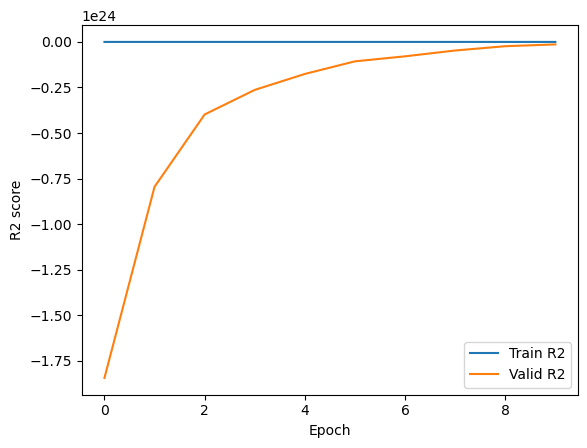

In [97]:
import matplotlib.pyplot as plt

plt.plot(train_r2_scores, label='Train R2')
plt.plot(valid_r2_scores, label='Valid R2')
plt.xlabel('Epoch')
plt.ylabel('R2 score')
plt.legend()
plt.show()

# Predict

In [79]:
X_test = torch.tensor(get_input_data(test, True))
test_preds = model(X_test).detach().numpy()
test_preds = pd.DataFrame(test_preds, columns=filtered_target_cols)

# Write submission file

In [62]:
# /kaggle/input/leap-atmospheric-physics-ai-climsim
weights = pd.read_csv(f"{data_path}/sample_submission.csv", nrows=1)
weights = weights.drop(['sample_id'], axis=1).T.to_dict()[0]

In [89]:
set(filtered_target_cols) - set(test_preds.columns)

set()

In [90]:
submission = pd.read_csv(f"{data_path}/sample_submission.csv")

for col in tqdm(filtered_target_cols):
    if weights[col] > 0:
        submission[col] = test_preds[col].values
    else:
        submission[col] = 0.
        
submission.to_csv('submission.csv', index=False)        
submission.head()

100%|██████████| 302/302 [00:05<00:00, 54.49it/s]


,sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,...,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
0,test_169651,-0.545411,0.656683,0.819095,1.322784,-0.510279,2.020569,-0.288234,1.420132,-2.635216,...,3.590868,-1.014814,-0.319090,4.114001,-1.387763,-0.797865,-1.210394,-1.609248,-0.033920,2.197917
1,test_524862,-0.609285,2.108539,0.563204,1.192242,-0.553749,0.623614,-1.520159,0.820504,-3.073966,...,2.149581,2.065135,-0.206421,2.331555,-2.456176,0.675187,-0.273587,-1.956471,-1.625339,2.244554
2,test_634129,-1.213737,-0.114074,1.432602,0.015002,-0.166612,2.268651,-0.503124,3.613167,-4.739151,...,3.533390,2.110069,-0.673640,2.688759,-2.469991,-0.049785,-0.316239,-0.911005,-3.096332,1.462231
3,test_403572,-0.008903,-0.313070,0.917899,3.203015,1.355351,0.258972,-0.507111,0.792349,-5.267419,...,2.115077,1.309831,-0.987785,2.151760,-1.539400,-1.501522,0.057080,-0.864071,0.142043,-0.081925
4,test_484578,-1.587302,2.319473,0.190565,-0.100965,0.629180,-0.967829,-0.126905,1.534175,-2.267677,...,1.745634,2.064975,-0.777585,3.215446,-1.214559,0.714900,-0.188883,-1.980971,0.692985,2.850944
